In [1]:
import matplotlib
import os
import numpy
import json
import collections
from matplotlib.pyplot import cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

In [2]:
def scaling_analysis(_bases, _title, _plot_name):
    # If the following is true, the graph datasets are coloured 
    # by routine name (for example, Stokes.solve()) . Otherwise, it's done by
    # set name (for example, "Magnus 16^3 Order 1" )
    graph_by_routine = True

    if not graph_by_routine:
        # titles for the graph legend
        graph_config = [
        ("Magnus 16^3 Order 1",  "green", "--"),
        ("Magnus 32^3 Order 1",   "blue", "--"),
        ("Magnus 64^3 Order 1",    "red", "--"),
        ("Magnus 16^3 Order 2", "yellow", "--"),
        ("Gadi   16^3 Order 1",  "green", "-"),
        ("Gadi   32^3 Order 1",   "blue", "-"),
        ("Gadi   64^3 Order 1",    "red", "-"),
        ("Gadi    8^3 Order 2", "purple", "-"),
        ("Gadi   16^3 Order 2", "yellow", "-"),
        ]
        keys       = [data[0] for data in graph_config]
        cols       = [data[1] for data in graph_config]
        linestyles = [data[2] for data in graph_config]
    else:
        linestyles = ['-','--',':','-','--',':','-','--',':']

    linewidths = [1.,1.0,1.0,1.,1.0,1.0,1.,1.0,1.0]

    # the following can limit the range of proc counts viewed
    maxproc = 9999999
    minproc = 0

    # if true, use listed functions below, otherwise auto find slowest funcs
    funcs_explicit = True
    funcs_auto_how_many = 7
    if funcs_explicit:
        funcs = [
         'FeMesh_Annulus.__init__()',
         'FeMesh_SRegion.__init__()',
         'FeMesh.save()',
         'Function.evaluate()',
         'MeshVariable.save()',
         'Swarm.load()',
         'Swarm.save()',
         'SwarmVariable.load()',
         'SwarmVariable.save()',
         'StokesSolver.solve()',
         'Total Time (UW2 API)',
         'Total Time (Runtime)'
        ]

    ignore_funcs = [
    #     'Container_Launch_Time',
    ]
    
    !find . -name Results_\* -type d
    
    # Each simulation stores it's timing data in a different file. 
    # Here we grab all required files.
    # Note wildcards, glob.glob() etc. 
    nrpoc_set = set()
    def grab_files(base):
        global nprocmax
        global maxconfig
        global done
        jsonguy = collections.defaultdict(lambda: [])
        for filename in glob.glob(base+"*.json"):
            with open(filename, 'r') as f:
                data = json.load(f)
                splitbase = filename.split(base)
                splitfile = splitbase[1].split("_")
                res = int(splitfile[1])
                nproc = int(splitfile[3])
                if nproc < minproc:
                    continue
                if nproc > maxproc:
                    continue
                nrpoc_set.add(nproc)
                print(filename)
    #             print("VRMS = {}".format(data[u'Other_data']["vrms"]))
    #             print("Res = {}".format(res))
    #             print("nproc = {}".format(nproc))
                jsonguy[(res,nproc)].append(data)
                if nproc>nprocmax and not done:
                    nprocmax = nproc
                    maxconfig = (res,nproc)
        done = True
        return jsonguy
    jsons = []
    for baseguy in _bases: 
        jsons.append(grab_files(baseguy))
        
    # Lets add in other_timing data
    # This is data not recorded by `uw.timing` module, and is explicitly 
    # recorded into the outputted json file.  This is used for Python load time
    # and container start time. 
    for jsonguy in jsons:
    #     print(jsonguy)
        for key,listjsons in jsonguy.items():
    #         print(key, listjsons)
            for guy in listjsons:
                print('-----------------------------')
    #             print(guy)
    #             othertiming =  guy[u'Other_timing']
    #             for otherk, otherv in othertiming.items():
    #                 othertiming[otherk] = [1, otherv]
    #             guy.update(othertiming)
    
    if not funcs_explicit:
        guy32 = jsons[0][maxconfig][0]
        list32 = []
        for key,val in guy32.items():
            if isinstance(val,list):
                list32.append([key,val[1]/float(val[0])])
        sortedlist = sorted(list32, key=lambda x: x[1], reverse=True) 
        funcs = []
        totmax = funcs_auto_how_many
        tot = 0
        for guy in sortedlist:
            tot+=1
            if tot > totmax:
                break
            if guy[0] in ignore_funcs:
                continue
            funcs.append(guy[0])
    funcs
    
    # Collect data from jsons
    def collect_data_from_jsons(jsonguy):
        funcdat = collections.defaultdict(lambda: [])
        for key,data in jsonguy.items():                      # all dicts
            for func in funcs:                                # funcs we want to look at
                for datum in data:                            # all runs for each res/nproc combo
                    if func in datum:
                        datguy = datum[func]
                        dat = (key[0],key[1],datguy[1]/float(datguy[0]))
                        funcdat[func].append(dat)
                    else:
                        print("{} not found in {}. Skipping".format(func,key))
                        continue
        return funcdat
    funcdats = []
    for jsonguy in jsons:
        result = collect_data_from_jsons(jsonguy)
        if result:
            funcdats.append(result)
            
    # get averages if multiple datasets for given nproc/res
    def get_averages(funcdatguy):
        avfuncdat = collections.defaultdict(lambda: [])
        for key, value in funcdatguy.items():
            counts = collections.defaultdict(lambda: [0,0.])
            for entry in value:
                dat = counts[entry[1]]
                dat[0]+=1
                dat[1]+=entry[2]
            for nproc, countdat in counts.items():
                avfuncdat[key].append((0,nproc,countdat[1]/float(countdat[0])))
        return avfuncdat
    avfuncdats = []
    for funcdat in funcdats:
        avfuncdats.append(get_averages(funcdat))
    dats = avfuncdats
    
    # plot
    font = {'family' : 'normal',
    #         'weight' : 'bold',
            'size'   : 8}
    matplotlib.rc('font', **font)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(dpi=300, figsize=(8.27, 11.69/2.))
    ax = plt.subplot(1,1,1,xscale='log', yscale='log')
    # ax.set_title("Save operations")
    ax.set_xlabel("nprocs")
    ax.set_ylabel("time(s)")
    sortedprocs = sorted(list(nrpoc_set))
    ax.xaxis.set_ticks(sortedprocs)
    ax.xaxis.set_ticklabels(sortedprocs, rotation=-70)
    ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
    ax.grid(axis="x", linestyle=':',linewidth=0.2)
    plt.title(_title)

    for index, dat in enumerate(dats):
        colind = 0
        for key, value in dat.items():
            xy = []
            for entry in value:
                xy.append((entry[1],entry[2]))
            sorteddat = sorted(xy, key=lambda x: x[0], reverse=False) 
            if graph_by_routine:
                cols = cm.Set3(np.linspace(0,1,len(funcs)))
                if key=='Total_Runtime':
                    col = "black"
                    lw  = 1.5
                else:
                    col = cols[colind]
                    lw = 0.5
                keyg = key
                if index!=0: keyg=None
            else:
                keyg = keys[index]
                col  = cols[index]

            ax.plot([x[0] for x in sorteddat],[x[1] for x in sorteddat], label=keyg, color=col, linestyle=linestyles[index], marker='o', markersize=2,linewidth=linewidths[index])
            colind+=1
    ax.legend( prop={'family': 'monospace', 'size':5})
    fig.savefig(_plot_name+".png")
    return

In [3]:
# few parameters needed in the function
nprocmax = 0
done = False
# Below are the filenames to grab data from
bases = ["./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi/"]
title = r'Weak Scaling $(32\times48\times32)$'

./Results_Weak_thyagi2d_test_take1_DIM_2_BASE_128_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi
./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi
./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi/Res_128192256_Nproc_128_JobID_12551895.gadi-pbs.json
./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi/Res_256384512_Nproc_1024_JobID_12551896.gadi-pbs.json
./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi/Res_324864_Nproc_2_JobID_12551893.gadi-pbs.json
./Results_weak_scaling_spherical_DIM_3_BASE_32_48_64_ORDER_1_TOL_1e-3_PENALTY_1e-3_IO_0_Gadi/Res_6496128_Nproc_16_JobID_12551894.gadi-pbs.json
-----------------------------
-----------------------------
-----------------------------
-----------------------------
FeMesh_Annulus.__init__() not found in (128192256, 128). Skipping
Swarm.save() not found in (128192256, 128). Skipping
F

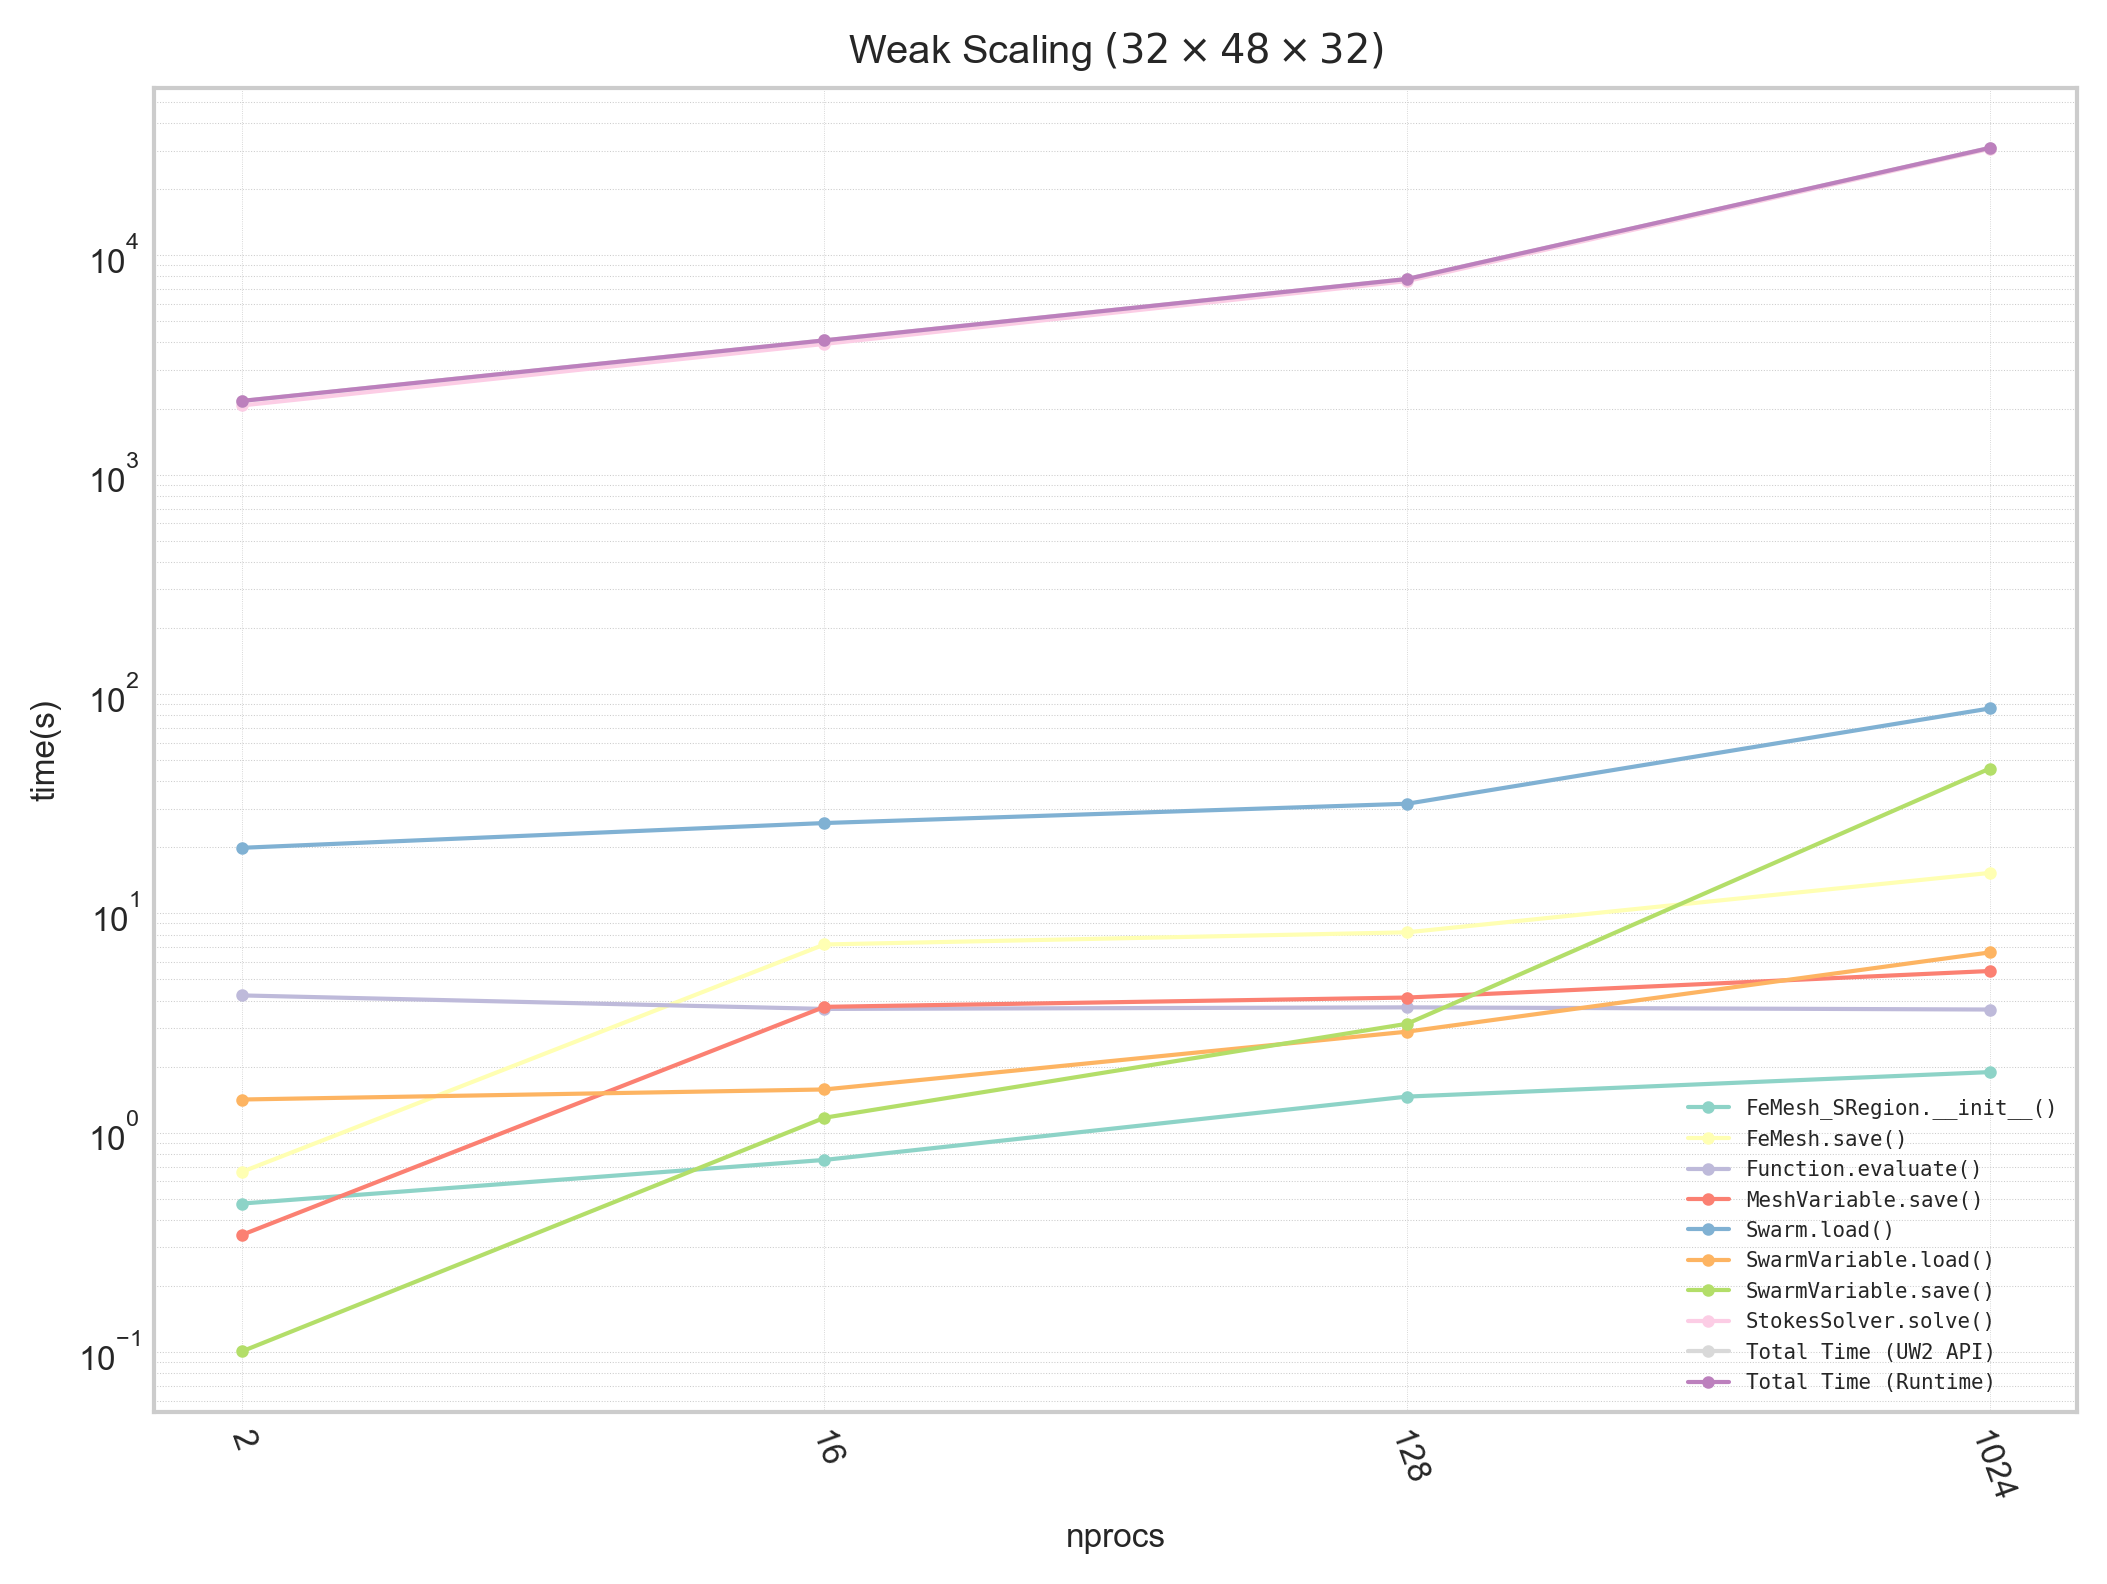

In [4]:
# doing analysis
weaking_scaling = scaling_analysis(bases, title, 'weak_scaling_3d')